So burger's eqution - let's skip all the internal dialogue and go to the cool part, no need to be fancy...

$$
\frac{\partial u}{\partial t}
+ u \frac{\partial u}{\partial x}
=
\nu \frac{\partial^2 u}{\partial^2 x}
$$

$$
\frac{u^{n+1}_{i} - u^{n}_{i}}{\Delta t}
+ u^{n}_{i} \frac{u^{n}_{i} - u^{n}_{i-1}}{\Delta x}
=
\nu \frac{u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1}}{\left(\Delta x\right)^2}
$$

and
$$
u^{n+1}_{i} 
= 
u^{n}_{i}
- u^{n}_{i} \frac{\Delta t}{\Delta x}
\left( 
    u^{n}_{i} - u^{n}_{i-1} 
\right)
+ \nu\frac{\Delta t}{\left(\Delta x\right)^2}
\left( 
    u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1} 
\right)
$$

## Initial Boundary Conditions

We will use the folowing as initial conditions for this problem:
$$
u = -\frac{2\nu}{\phi} \frac{\partial \phi}{\partial x}+ 4
$$
where $\phi$ is,
$$
\phi 
= \exp\left(\frac{-x^2}{4\nu}\right) 
+ \exp\left(\frac{-\left(x-2\pi\right)^2}{4\nu}\right)
$$

Incidentely, this one does have an analytical solution:
$$
\phi 
= \exp\left(\frac{-\left(x-4t\right)^2}{4\nu\left(t+1\right)}\right) 
+ \exp\left(\frac{-\left(x-4t-2\pi\right)^2}{4\nu\left(t+1\right)}\right)
$$

Our boundary condition will be,
$$
u(0) = u(2\pi)
$$

### Set up
```
vis = 0.1
nx = 20
dx = 2 / (nx-1)
nt = 50
dt = 0.01

for i = 1:nx
    ip1(i) = i+1
    im1(i) = i-1
      x(i) = (i-1)*dx
# Boundary conditions
ipl(nx) = 1 
iml(1)  = nx

for i = 1:nx
    phi = exp( -x(i)**2/(4*vis) ) + exp( -(x(i) - 2*pi)**2/(4*vis) )
    dphi = - 0.5/vis * x(i) * exp( -x(i)**2/(4*vis) ) 
           - 0.5/vis * (x(i) - 2*pi) * exp( -(x(i) - 2*pi)**2/(4*vis) )
    u(i) = - 2*vis*dphi/phi + 4
```

### Calculation
```
for it = 1:nt
    t = (it-1)*dt
    for i = i:nx
        phi =   exp( -(x(i) - 4*t)**2/(4*vis*(t+1)) ) 
              + exp( -(x(i) - 4*t - 2*pi)**2/(4*vis*(t+1)) )
        dphi = - 0.5/(vis*(t+1)) * (x(i)-4*t) * exp( -(x(i)-4*t)**2/(4*vis*(t+1)) )
               - 0.5/(vis*(t+1)) * (x(i)-4*t-2*pi) * exp( -(x(i)-4*t-2*pi)**2/(4*vis*(t+1)) )
        ua(i) = - 2*vis*dphi/phi + 4
        
    un = u
    for i = 1:nx
        u(i) = un(i) - un(i)*(dt/dx)*(un(i) - un(im1(i))) 
                    + vis*(dt/dx**2)*( un(ip1(i)) - 2*un(i) + un(im1(i)) )
```

In [29]:
%matplotlib inline
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

sp.init_printing(use_latex='mathjax', fontsize='30pt')

In [34]:
x, nu, t = sp.symbols('x nu t')

phi = (
    sp.exp(-(x - 4*t)**2 / (4*nu*(t + 1))) 
    + sp.exp(-(x - 4*t - 2*sp.pi)**2 / (4*nu*(t + 1)))
)
phi

                  2                2 
 -(-4⋅t + x - 2⋅π)      -(-4⋅t + x)  
 ───────────────────    ─────────────
     4⋅ν⋅(t + 1)         4⋅ν⋅(t + 1) 
ℯ                    + ℯ             

In [35]:
phiprime = phi.diff(x)
phiprime

                           2                                         2 
                -(-4⋅t + x)                         -(-4⋅t + x - 2⋅π)  
                ─────────────                       ───────────────────
                 4⋅ν⋅(t + 1)                            4⋅ν⋅(t + 1)    
  (-8⋅t + 2⋅x)⋅ℯ                (-8⋅t + 2⋅x - 4⋅π)⋅ℯ                   
- ─────────────────────────── - ───────────────────────────────────────
          4⋅ν⋅(t + 1)                         4⋅ν⋅(t + 1)              

In [36]:
u = -2 * nu * (phiprime / phi) + 4
ufunc = lambdify((t, x, nu), u)

# Computation

In [61]:
###variable declarations
nu = .07
L = 2.0
nx = 101
dx = L * np.pi / (nx - 1)
nt = 100
dt = dx * nu

x = np.linspace(0, L*np.pi, nx)
un = np.empty(nx)

t = 0
u = np.asarray([ufunc(t, x0, nu) for x0 in x])

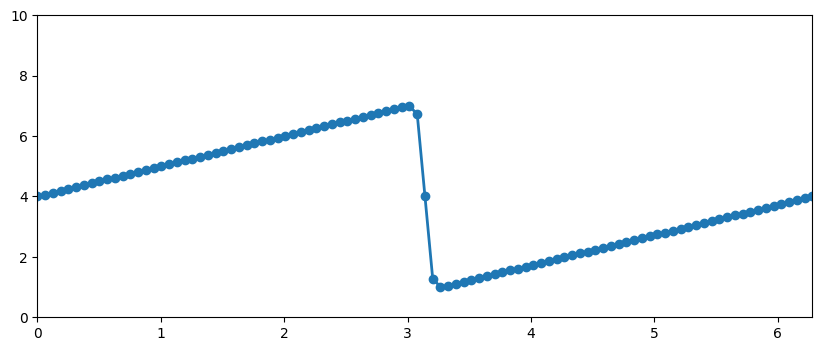

In [62]:
plt.figure(figsize=(10, 4), dpi=100)
plt.plot(x, u, marker='o', lw=2)
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10]);

In [63]:
for n in range(nt):
    un = u.copy()
    for i in range(1, nx-1): 
        u[i] = un[i] - un[i]*(dt/dx)*(un[i] - un[i-1]) +\
                    nu*(dt/dx**2)*(un[i+1] - 2*un[i] + un[i-1])
            
    # PBC - we are iterating from 0 to "-2" because of central diff terms.
    u[0] = un[0] - un[0]*(dt/dx)*(un[0] - un[-2]) +\
                nu*(dt/dx**2)*(un[1] - 2*un[0] + un[-2])
    u[-1] = u[0]

In [64]:
u_analytical = np.asarray([ufunc(nt*dt, xi, nu) for xi in x])

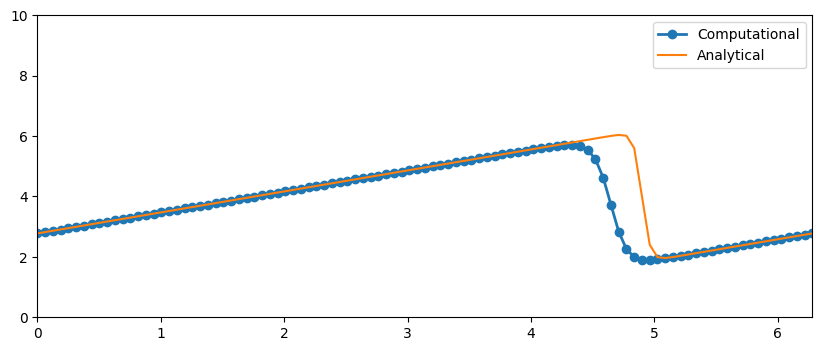

In [65]:
plt.figure(figsize=(10, 4), dpi=100)
plt.plot(x,u, marker='o', lw=2, label='Computational')
plt.plot(x, u_analytical, label='Analytical')
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10])
plt.legend();

In [97]:
###variable declarations
nu = .07
L = 2.0
nx = 101
dx = L * np.pi / (nx - 1)
nt = 800
dt = dx * nu

x = np.linspace(0, L*np.pi, nx)
un = np.empty(nx)

t = 0
u = np.asarray([ufunc(t, x0, nu) for x0 in x])

fig, ax = plt.subplots()
ax.set_xlim((0, L*np.pi))
ax.set_ylim((0, 8))
line, = ax.plot([], [], lw=2, label="label")
leg = ax.legend(loc=2, prop={'size': 10})

def animate(n):
    un = u.copy()
    for i in range(1, nx-1):
        u[i] = un[i] - un[i]*(dt/dx)*(un[i] - un[i-1]) +\
                    nu*(dt/dx**2)*(un[i+1] - 2*un[i] + un[i-1])
            
    # PBC
    u[0] = un[0] - un[0]*(dt/dx)*(un[0] - un[-2]) +\
                nu*(dt/dx**2)*(un[1] - 2*un[0] + un[-2])
    u[-1] = u[0]
    
    line.set_data(np.linspace(0, L*np.pi, nx), u)
    leg.texts[0].set_text("t = {}".format(n))
    return line, leg

# Analytical solution
u_analytical = np.asarray([ufunc(100*dt, xi, nu) for xi in x])
ax.plot(x, u_analytical, label='Analytical')

anim = animation.FuncAnimation(fig, animate, frames=nt, interval=50, blit=True)
plt.close()

In [98]:
HTML(anim.to_html5_video())